##### LSTM
- 참고 링크 : https://github.com/puzzlecollector/DACON-fake-news-identification

In [1]:
import glob
import pandas as pd
from tensorflow import keras
import numpy as np
import os 
from sklearn.model_selection import StratifiedKFold
import matplotlib.pylab as plt
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, concatenate, Input, Reshape, Flatten, LSTM, Dense, Dropout
from tensorflow.keras.layers import Embedding, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import , load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import re 

import nltk # for stopwords 
from nltk.corpus import stopwords
import gensim # for Word2Vec embeddings 
from sklearn.feature_extraction.text import CountVectorizer

from konlpy.tag import Mecab

In [3]:
train = pd.read_csv('news_train.csv')
test = pd.read_csv('news_test.csv') 
submission = pd.read_csv('sample_submission.csv')

In [4]:
#padded data는 모두 mecab.morphs를 활용하여 Tokenizing진행

y_train = np.load('y_train.npy') 
train_title = np.load('train_title_padded_x.npy')
train_content = np.load('train_content_padded_x.npy')
test_content = np.load('test_content_padded.npy') 
test_title = np.load('test_title_padded.npy') 

train_title.shape, train_content.shape, test_content.shape, test_title.shape

((118745, 23), (118745, 61), (142565, 61), (142565, 23))

In [5]:
vocab_content = 41573 
vocab_title = 9197 
embedding_vec_title = 16 
embedding_vec_content = 64

title_length = 23 
content_length = 61

In [11]:
def build_model():
    
    input_title = Input((title_length))
    input_content = Input((content_length))
    
    
    emb_title = Embedding(vocab_title, embedding_vec_title)(input_title)
    lstm_title = Bidirectional(LSTM(128, return_sequences=False))(emb_title)

    
    emb_text = Embedding(vocab_content, embedding_vec_content)(input_content)
    lstm_text = Bidirectional(LSTM(128, return_sequences=True))(emb_text)

    
    max_pool_text = GlobalMaxPool1D()(lstm_text)
    dropout_1_text = Dropout(0.1)(max_pool_text)
    dense_1_text = Dense(64, activation='relu')(dropout_1_text)
    dropout_2_text = Dropout(0.1)(dense_1_text)

    
    out = concatenate([lstm_title,dropout_2_text],axis=-1)
    output=Dense(1, activation='sigmoid')(out)

    
    model = Model(inputs=[input_title, input_content], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 61)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 61, 64)       2660672     input_2[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 61, 256)      197632      embedding_5[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d (GlobalMax (None, 256)          0           bidirectional_1[0][0]            
______________________________________________________________________________________________

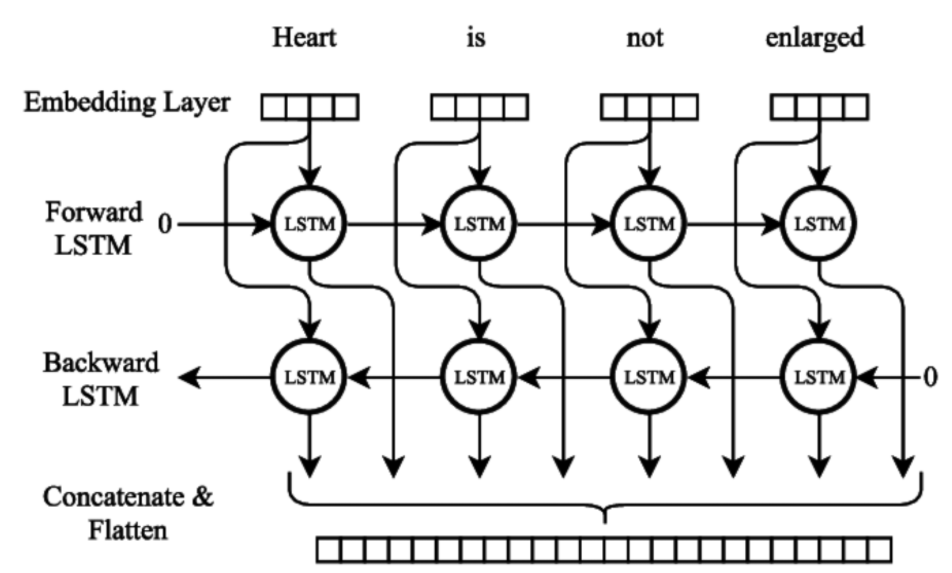

In [19]:
import os

if 'model' not in os.listdir():
    print('making "model" Folder . . .')
    os.mkdir('model')

model_path = '/model/epoch_{epoch:03d}_val_{val_loss:.3f}.h5'

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 

history = model.fit(x=[train_title,train_content],
                    y=y_train,
                    batch_size=128,
                    epochs=200,
                    verbose=1,
                    validation_split = 0.2, 
                    callbacks = [learning_rate_reduction,checkpoint,early_stopping])

Epoch 1/200
741/743 [============================>.] - ETA: 0s - loss: 0.0080 - accuracy: 0.9976
Epoch 00001: val_loss improved from inf to 0.06002, saving model to /model/epoch_001_val_0.060.h5
743/743 [==============================] - 19s 26ms/step - loss: 0.0080 - accuracy: 0.9976 - val_loss: 0.0600 - val_accuracy: 0.9789 - lr: 0.0010
Epoch 2/200
743/743 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.9991
Epoch 00002: val_loss improved from 0.06002 to 0.04461, saving model to /model/epoch_002_val_0.045.h5
743/743 [==============================] - 19s 25ms/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0446 - val_accuracy: 0.9874 - lr: 0.0010
Epoch 3/200
742/743 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.9994
Epoch 00003: val_loss did not improve from 0.04461
743/743 [==============================] - 19s 25ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 0.0556 - val_accuracy: 0.9859 - lr: 0.0010
Epoch 4/200
743/743 

- 모델링에 대해 공부할것이 아직도 너무 많다고 생각됨
- 모델 내에서 output 값을 만들어내는 과정이 아직도 잘 이해는 안됨. 보면서 이해는 하겟지만, 직접구현은 아직 상당히 무리일듯함
- 차원 또한 너무 크지 않아 성능도 좋을 뿐더러 , 속도또한 상당히 빠른편